In [25]:
from brix import Indicator, Handler
import Simulation, US_State
import geopandas as gpd
from shapely.geometry import Point, shape
import json
import requests
import urllib
from geogrid_tools import *

In [26]:
table_name='epa_'
geom_type='block_group'

model_radius=15000
reference_radius=2500

- Create the handler
- Get the geogrid
- Identify the state
- Get the state geometry
- find the overlap
- Assign the sim, model, reference zones
- Append the grid "zones" to the actual zones (if the zones properties are updated in one indicator, will they be updated for all?)

- all the above in a world object?

In [27]:
h=Handler(table_name)

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/epa_/meta/hashes/ Attempt: 0


In [4]:
# geogrid_data=h.get_geogrid_data(include_geometries=True)

In [5]:

# geogrid=geogrid_data.GEOGRID

In [6]:
# geogrid=h.get_GEOGRID()
# geom = [f['geometry'] for f in geogrid['features']]
# geogrid_gdp=gpd.GeoDataFrame({'geometry':geom})

In [28]:
get_url='https://cityio.media.mit.edu/api/table/'+table_name
with urllib.request.urlopen(get_url+'/GEOGRID') as url:
    geogrid=gpd.read_file(url.read().decode())

centroids=geogrid['geometry'].centroid
geogrid['x_centroid']=[c.x for c in centroids]
geogrid['y_centroid']=[c.y for c in centroids]
geogrid

/var/folders/30/clhynt5s7fx_3nyyxfl04f780000gn/T/ipykernel_20431/1794812704.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=geogrid['geometry'].centroid


,id,interactive,name,geometry,x_centroid,y_centroid
0,0,Web,None,"POLYGON ((-122.15634 37.47000, -122.15603 37.4...",-122.155916,37.469909
1,1,Web,None,"POLYGON ((-122.15580 37.47025, -122.15549 37.4...",-122.155377,37.470156
2,2,Web,None,"POLYGON ((-122.15526 37.47049, -122.15495 37.4...",-122.154838,37.470403
3,3,Web,None,"POLYGON ((-122.15472 37.47074, -122.15441 37.4...",-122.154298,37.470650
4,4,Web,None,"POLYGON ((-122.15418 37.47099, -122.15387 37.4...",-122.153759,37.470897
...,...,...,...,...,...,...
2745,2745,Web,None,"POLYGON ((-122.11534 37.45790, -122.11503 37.4...",-122.114920,37.457813
2746,2746,Web,None,"POLYGON ((-122.11480 37.45815, -122.11449 37.4...",-122.114380,37.458060
2747,2747,Web,None,"POLYGON ((-122.11427 37.45840, -122.11396 37.4...",-122.113841,37.458307
2748,2748,Web,None,"POLYGON ((-122.11373 37.45864, -122.11342 37.4...",-122.113302,37.458554


In [29]:
types=json.load(open('./data/default_types.json'))

In [30]:
try:
    interactive_zone=gpd.read_file('./tables/{}/interactive.geojson'.format(table_name))
    print('using interactive zone')
except:
    interactive_zone=None
properties=init_geogrid(table_name, interactive_zone=interactive_zone, types=types)

using interactive zone
Initialise GEOGRID: <Response [200]>


In [31]:
state_fips=identify_state(properties)

Getting geometry (block_group) for state: California


/Users/ronandoorley/Documents/Media_Lab/CityScope/CS_Spatial_Modules/US_State.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data


<AxesSubplot:>

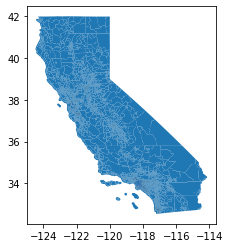

In [32]:
st=US_State.US_State(state_fips, year=2018, geom_type=geom_type)
st.get_geometry()
# st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac', 'od'])
st.add_lodes_cols_to_shape()
st.geom.plot()

In [33]:
st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=reference_radius, name='reference_area')

st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=model_radius, name='model_area')

st.geom=assign_sim_area(gpd.GeoDataFrame(geogrid), st.geom)

	 Subsetting zones by distance
	 Subsetting zones by distance


/Users/ronandoorley/Documents/Media_Lab/CityScope/CS_Spatial_Modules/geogrid_tools.py:63: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  grid_intersect_zones=gpd.overlay(geogrid, zones, 'intersection')


In [34]:
geogrid_union=gpd.GeoDataFrame(geometry=[geogrid.geometry.unary_union], data=[], crs=geogrid.crs)
sim_geoids=select_geom_by_overlap_threshold(areas_to_filter=st.geom, filter_with=geogrid_union, 
                                            area_id_col='copy_GEOID', 
                                            min_prop=0.5)
st.geom['sim_area']=False
st.geom.loc[sim_geoids, 'sim_area']=True

/Users/ronandoorley/Documents/Media_Lab/CityScope/CS_Spatial_Modules/geogrid_tools.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_to_filter['zone_area']=areas_to_filter.geometry.area
/Users/ronandoorley/Documents/Media_Lab/CityScope/CS_Spatial_Modules/geogrid_tools.py:77: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_intersect['intersect_area']=all_intersect.geometry.area


<AxesSubplot:>

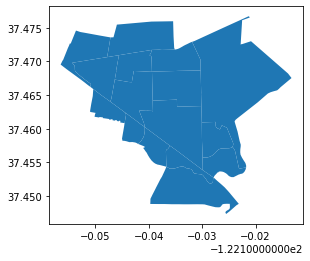

In [35]:
st.geom.loc[st.geom['sim_area']].plot()

In [36]:
areas_to_filter=st.geom
filter_with=geogrid
area_id_col='copy_GEOID'
min_prop=0.5
intersector_id_col='id'

areas_to_filter['zone_area']=areas_to_filter.geometry.area
all_intersect=gpd.overlay(areas_to_filter, filter_with, 'intersection')
all_intersect['intersect_area']=all_intersect.geometry.area
all_intersect=all_intersect[[col for col in all_intersect if not col=='zone_area']]
all_intersect=all_intersect.merge(areas_to_filter[[area_id_col, 'zone_area']], 
                                how='left', left_on=area_id_col, right_on=area_id_col)
all_intersect['prop_area']=all_intersect['intersect_area']/all_intersect['zone_area']
valid_intersect=all_intersect.loc[all_intersect['prop_area']>min_prop]
valid_ids=list(valid_intersect[area_id_col])



/var/folders/30/clhynt5s7fx_3nyyxfl04f780000gn/T/ipykernel_20431/2596693682.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_to_filter['zone_area']=areas_to_filter.geometry.area
/var/folders/30/clhynt5s7fx_3nyyxfl04f780000gn/T/ipykernel_20431/2596693682.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_intersect['intersect_area']=all_intersect.geometry.area


In [37]:
zones=st.geom.rename(columns={col: 'area' for col in st.geom.columns if 'ALAND' in col})

In [38]:
import os
if not os.path.isdir('tables/{}'.format(table_name)):
    os.mkdir('tables/{}'.format(table_name))

In [39]:
zones.loc[zones['model_area']].to_file('tables/{}/zones.geojson'.format(table_name), driver='GeoJSON')

In [21]:
simpop_df=st.lodes_to_pop_table(
    model_subset_name='model_area', sim_subset_name='sim_area')
simpop_df.to_csv('tables/{}/simpop_df.csv'.format(table_name), index=False)

Using 2505 of 8853068 rows in OD data
0 of 2505


In [40]:
geogrid.to_file('tables/{}/geogrid.geojson'.format(table_name), driver='GeoJSON')

In [23]:
assert len(zones.loc[((zones['sim_area'])&(~zones['reference_area']))])==0

<AxesSubplot:>

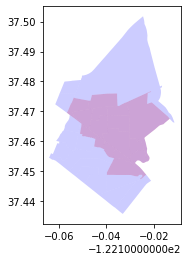

In [24]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots()

zones.loc[zones['sim_area']].plot(ax=ax, color='red', alpha=0.2)
zones.loc[zones['reference_area']].plot(ax=ax, color='blue', alpha=0.2)